Copyright (c) 2021 Reverie Labs. All rights reserved. This work is licensed under the terms of the [MIT license](https://opensource.org/licenses/MIT).

# Mapping Chemical Space with UMAP
This notebook walks you through creating a 2D visualization of a chemical dataset with UMAP, using the Blood Brain Barrier Permeability (BBBP) dataset from [MoleculeNet](http://moleculenet.ai/datasets-1). We show you how to install the relevant packages, embed your smiles as [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t), then reduce those high-dimensional vectors down to 2 dimensions with both Dataset-Specific and Dataset-Agnostic embeddings. We also include PCA and T-SNE embeddings for comparison.  

<br> For an analysis of the structure of these embeddings, and explanation of terms, please see the [blog post](https://blog.reverielabs.com/mapping-chemical-space-with-umap) that accompanies this Colab.


# Imports & Utils

In [ ]:
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

In [ ]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [ ]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None


def compute_ecfp_descriptors(smiles_list: List[str]):
    """Computes ecfp descriptors"""

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx


def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

In [ ]:
def plot_global_embeddings_with_clusters(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    cluster_col: str,
    title: str = "",
    x_lim=None,
    y_lim=None,
):
    """Plots data colored by soft HDBSCAN clusters

    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0

    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        data=df.iloc[~clustered],
        x=x_col,
        y=y_col,
        color=(0.5, 0.5, 0.5),
        s=10,
        alpha=0.1,
    )
    sns.scatterplot(
        data=df.iloc[clustered],
        x=x_col,
        y=y_col,
        hue=cluster_col,
        alpha=0.5,
        palette="nipy_spectral",
        ax=ax,
    )
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")

    plt.title(title)
    plt.show()

# Embed BBBP with UMAP, PCA, t-SNE (Dataset-Specific Embeddings)

### Read in and process data

In [ ]:
# Read in data from MoleculeNet
bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
bbbp = (
    bbbp[["smiles", "p_np", "name"]]
    .reset_index(drop=True)
    .rename({"p_np": "permeable"}, axis=1)
)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()

### Compute ECFP Descriptors

In [ ]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

### Embed with UMAP

In [ ]:
%%time
umap_model = umap.UMAP(
    metric="jaccard", n_neighbors=25, n_components=2, low_memory=False, min_dist=0.001
)
X_umap = umap_model.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = X_umap[:, 0], X_umap[:, 1]

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CPU times: user 32.7 s, sys: 266 ms, total: 33 s
Wall time: 28.4 s


### Embed with PCA

In [ ]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_0"], bbbp["PCA_1"] = X_pca[:, 0], X_pca[:, 1]

CPU times: user 568 ms, sys: 378 ms, total: 946 ms
Wall time: 513 ms


### Embed with t-SNE

In [ ]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_0"], bbbp["TNSE_1"] = X_tsne[:, 0], X_tsne[:, 1]

CPU times: user 56.4 s, sys: 204 ms, total: 56.7 s
Wall time: 39.5 s


### Visualize the dataset embeddedings

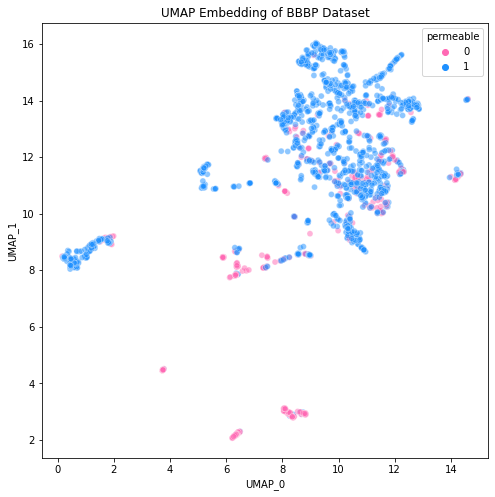

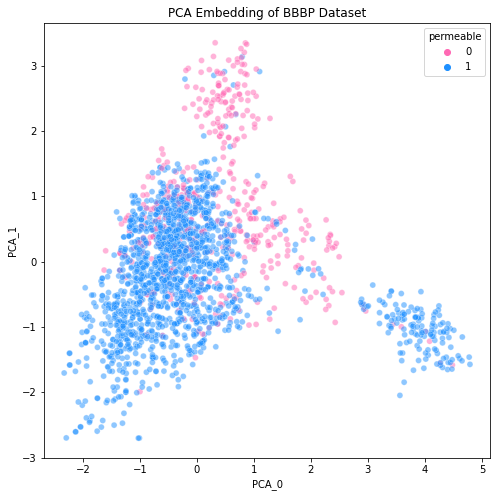

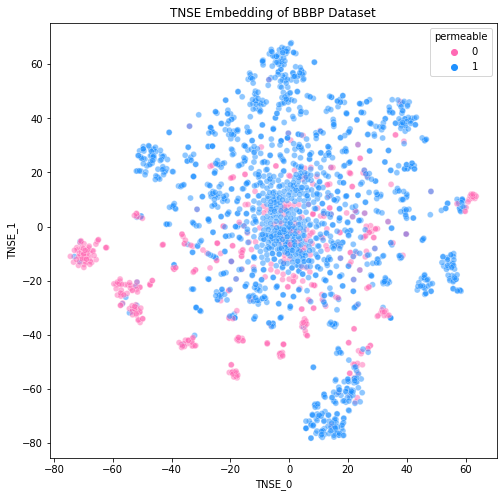

In [ ]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["UMAP", "PCA", "TNSE"]:
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        data=bbbp,
        x=f"{method}_0",
        y=f"{method}_1",
        hue="permeable",
        alpha=0.5,
        palette=palette,
    )
    plt.title(f"{method} Embedding of BBBP Dataset")
    plt.show()

# Embed BBBP in Global Chemical Space Approximation (Dataset-Agnostic Embedding)

### Read in and process ChEMBL data
_Note: We want this walk-through to be fully reproducible with publicly available data. Since the dataset we used at Reverie create our internal Dataset-Agnostic Embedding can't be shared here, instead we select a random sample of ChEMBL compounds as our approximation of global chemical space._

In [ ]:
# Read in data from MoleculeNet
chembl = pd.read_csv(
    "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/chembl_sparse.csv.gz",
    compression="gzip",
)

# Sample a random 10k
chembl_sample = chembl.sample(n=10000)

### Compute ECFP descriptors

In [ ]:
%%time
# Compute desrciptors and keep track of which failed to featurize
chembl_ecfp_descriptors, chembl_keep_idx = compute_ecfp_descriptors(
    chembl_sample["smiles"]
)

# Only keep those that sucessfully featurized
chembl_sample = chembl_sample.iloc[chembl_keep_idx]

CPU times: user 1min 4s, sys: 2.35 s, total: 1min 6s
Wall time: 1min 7s


### Embed 'global' sample with UMAP to create Dataset-Agnostic model

In [ ]:
%%time
umap_model_global = umap.UMAP(
    metric="jaccard", n_neighbors=25, n_components=2, low_memory=False, min_dist=0.001
)
X_umap_global = umap_model_global.fit_transform(chembl_ecfp_descriptors)
chembl_sample["UMAP_0"], chembl_sample["UMAP_1"] = (
    X_umap_global[:, 0],
    X_umap_global[:, 1],
)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CPU times: user 1min 8s, sys: 423 ms, total: 1min 8s
Wall time: 48.4 s


### Use Dataset-Agnostic UMAP model to embed BBBP

In [ ]:
%%time
X_umap_bbbp = umap_model_global.transform(ecfp_descriptors)
bbbp["UMAP_0 (global)"], bbbp["UMAP_1 (global)"] = X_umap_bbbp[:, 0], X_umap_bbbp[:, 1]

CPU times: user 38.9 s, sys: 239 ms, total: 39.2 s
Wall time: 37.9 s


### Fit HDBScan clustering model on 'global' data & use to cluster BBBP

In [ ]:
# Define HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=10,
    prediction_data=True,
    cluster_selection_method="eom",
)

# Fit and predict on ChEMBL-sample
chembl_sample["global_cluster"] = hdbscan_model.fit_predict(X_umap_global)

# Use ChEMBL-sample HDBSCAN model to cluster BBBP data
bbbp["global_cluster"], _ = hdbscan.approximate_predict(
    hdbscan_model, np.nan_to_num(X_umap_bbbp, nan=0)
)

### Visualize Dataset-Agnostic BBBP Embedding and Global Chemical Space Approximation (colored by global cluster)
* Because this is a soft clustering, some compounds don't end up getting assigned a cluster (their cluster value = 0)
* These compounds that do not end up in clusters are colored gray in these depictions
* With a larger 'global approximation' dataset than this 10k sample you are likely to have more compounds in the BBBP dataset that are represented by global clusters

In [ ]:
# Determine axes limits to put plots on the same scale
buffer_space = 0.5  # Extra space around the edges
x_lim = (
    chembl_sample["UMAP_0"].min() - buffer_space,
    chembl_sample["UMAP_0"].max() + buffer_space,
)
y_lim = (
    chembl_sample["UMAP_1"].min() - buffer_space,
    chembl_sample["UMAP_1"].max() + buffer_space,
)

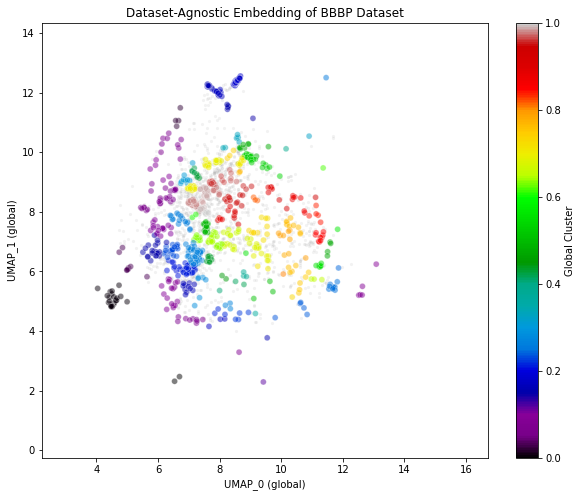

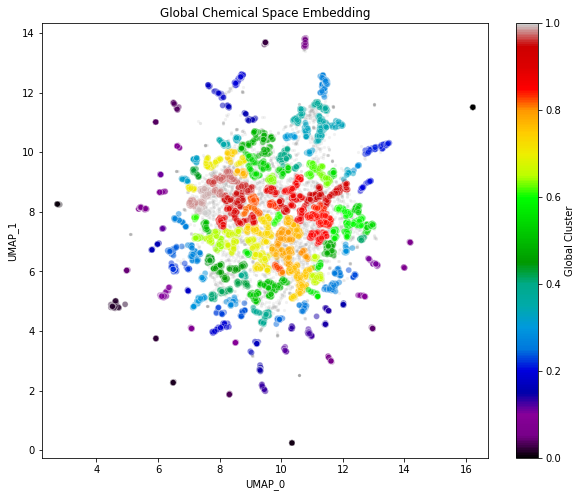

In [ ]:
plot_global_embeddings_with_clusters(
    bbbp,
    x_col="UMAP_0 (global)",
    y_col="UMAP_1 (global)",
    x_lim=x_lim,
    y_lim=y_lim,
    cluster_col="global_cluster",
    title="Dataset-Agnostic Embedding of BBBP Dataset",
)

plot_global_embeddings_with_clusters(
    chembl_sample,
    x_col="UMAP_0",
    y_col="UMAP_1",
    x_lim=x_lim,
    y_lim=y_lim,
    cluster_col="global_cluster",
    title="Global Chemical Space Embedding",
)